In [12]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import keras

# load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

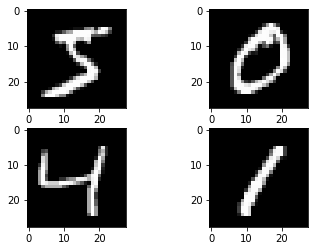

In [13]:
plt.subplot(221)
plt.imshow(X_train[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1], cmap = plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3], cmap=plt.get_cmap('gray'))

In [14]:
#printing all shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28)
(10000, 28, 28)
(60000,)
(10000,)


In [15]:
# resizing the training data
X_train = X_train.reshape(X_train.shape[0],-1).T
X_test = X_test.reshape(X_test.shape[0],-1).T

In [16]:
# one hot encoding
m_train = X_train.shape[1]
m_test = X_test.shape[1]
Y_train = np.zeros((10,m_train))
Y_test = np.zeros((10,m_test))
for i in range(m_train):
    Y_train[y_train[i],i] = 1
for i in range(m_test):
    Y_test[y_test[i],i] = 1

print(Y_train.shape)
print(Y_test.shape)
print(Y_train[:,10])
print(Y_test[:,10])

(10, 60000)
(10, 10000)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
# to standardize the data
X_train = X_train / 255
X_test = X_test / 255
np.set_printoptions(threshold=1000)

In [7]:
np.random.seed(2303)

In [8]:
# initialize the parameters
def initialize_parameters_LL(layers_dims):
    
    parameters = {}
    L = len(layers_dims)
    for l in range(1,L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        
    return parameters

In [9]:
#check function correctness
parameters = initialize_parameters_LL([2,3,4])
parameters

{'W1': array([[-0.48450066,  0.38716704],
        [-1.66661405, -1.20598593],
        [-0.3980586 ,  0.15531319]]), 'b1': array([[0.],
        [0.],
        [0.]]), 'W2': array([[ 0.75494939, -0.41516074, -0.5207442 ],
        [ 1.48896379,  0.59062395,  1.29747577],
        [-0.30546362,  0.31313369, -1.28323228],
        [-0.35594005,  0.10722991,  0.83420531]]), 'b2': array([[0.],
        [0.],
        [0.],
        [0.]])}

In [10]:
def relu(Z):
    X = np.maximum(0,Z)
    return X

In [11]:
relu([1,-44,-5,3])

array([1, 0, 0, 3])

In [12]:
def sigmoid(Z):
    X = (1/(1 + np.exp(-1*Z)))
    return X

In [13]:
sigmoid(np.array([1,-44,-5,3]))

array([7.31058579e-01, 7.78113224e-20, 6.69285092e-03, 9.52574127e-01])

In [14]:
def forward_propagation(A, W, b, activation):
    
    Z = np.dot(W,A) + b
    if activation == 'relu':
        A = relu(Z)
    elif activation == 'sigmoid':
        A = sigmoid(Z)
    
    return A,Z

In [15]:
def forward_propagation_LL(parameters, X):
    
    cache = {}
    L = len(parameters)//2
    A = X
    
    for l in range(1,L):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        A,Z = forward_propagation(A, W, b,"relu")
        cache['A' + str(l)] = A
        cache['Z' + str(l)] = Z
    
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    A = cache['A' + str(L-1)]
    AL,Z = forward_propagation(A, W, b,"sigmoid")
    cache['A' + str(L)] = AL
    cache['Z' + str(L)] = Z
    cache['A' + str(0)] = X
    
    return AL, cache

In [16]:
def compute_cost(AL, Y, lambd, parameters):
    
    L = len(parameters) // 2
    m = Y.shape[1]
    cost = (-1/m)*np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
    regularization_cost = ((np.sum(np.square(parameters['W1'])) + np.sum(np.square(parameters['W2'])))*lambd)/(2*m)
    cost = np.squeeze(cost)
    cost = cost + regularization_cost
    return cost

In [17]:
def sigmoid_derivative(Z):
    A = sigmoid(Z)
    X = A*( 1 - A)
    return X

In [18]:
def relu_derivative(Z):
    X = 1*(Z>0)
    return X    

In [19]:
def back_propagation(dA, W, b, Z, A_prev, activation,lambd):
    if activation == 'sigmoid':
        dZ = dA * sigmoid_derivative(Z)
    elif activation == 'relu' :
        dZ = dA * relu_derivative(Z)
    
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ,A_prev.T) + (lambd*W)/m
    db = (1/m) * np.sum(dZ,axis = 1,keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [20]:
def back_propagation_LL(AL, parameters, cache, Y,lambd):
    
    gradients = {}
    m = AL.shape[1]
    L = len(parameters)//2
    dAL = -(np.divide(Y,AL) - np.divide(1-Y,1-AL))
    
    W = parameters['W' + str(L)]
    b = parameters['b' + str(L)]
    Z = cache['Z' + str(L)]
    A_prev = cache['A' + str(L-1)]
    
    gradients['dA'+str(L-1)],gradients['dW'+str(L)],gradients['db'+str(L)]=back_propagation(dAL,W,b,Z,A_prev,"sigmoid",lambd)
    
    for l in reversed(range(L-1)):
        W = parameters['W' + str(l+1)]
        b = parameters['b' + str(l+1)]
        Z = cache['Z' + str(l+1)]
        A_prev = cache['A' + str(l)]
        
        gradients['dA'+str(l)],gradients['dW'+str(l+1)],gradients['db'+str(l+1)] = back_propagation(gradients['dA'+str(l+1)],W,b,Z,A_prev,"relu",lambd)
        
    
    return gradients
        
    
    
    

In [21]:
def update_parameters_LL(parameters, gradients, learning_rate):
    
    L = len(parameters) // 2
    
    for l in range(1,L+1):
        parameters['W'+str(l)] = parameters['W'+str(l)] - learning_rate * gradients['dW' + str(l)]
        parameters['b'+str(l)] = parameters['b'+str(l)] - learning_rate * gradients['db' + str(l)]
        
    return parameters

In [22]:
def model_LL(X,Y,layers_dims,learning_rate,num_iterations,lambd):
    
    m = X.shape[1]
    
    parameters = initialize_parameters_LL(layers_dims)
    costs = []
    for i in range(num_iterations):
        
        AL, cache = forward_propagation_LL(parameters, X)
        
        cost = compute_cost(AL,Y,lambd,parameters)
        
        gradients = back_propagation_LL(AL, parameters, cache, Y,lambd)
        
        parameters = update_parameters_LL(parameters, gradients, learning_rate)
        
        if i % 50 == 0 :
            print("cost after ",i," iterations :", cost)
            costs.append(cost)
        
        #plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    
    return parameters

cost after  0  iterations : 6.830177908331182
cost after  50  iterations : 2.019241199508953
cost after  100  iterations : 1.4909654559471313
cost after  150  iterations : 1.2485882252621767
cost after  200  iterations : 1.1086976052648412
cost after  250  iterations : 1.017066513382951
cost after  300  iterations : 0.9521565804304415
cost after  350  iterations : 0.9035079971348965
cost after  400  iterations : 0.8654136892016303
cost after  450  iterations : 0.8345464520281732
cost after  500  iterations : 0.808770663782328
cost after  550  iterations : 0.786794737572157
cost after  600  iterations : 0.7676561620889534
cost after  650  iterations : 0.7506581552642537
cost after  700  iterations : 0.7354092266108514
cost after  750  iterations : 0.721572508143973


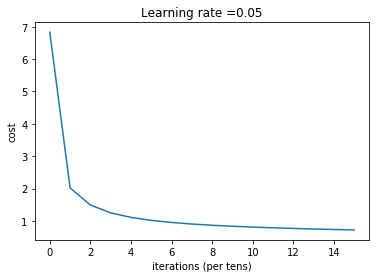

In [47]:
parameters = model_LL(X_train, Y_train, [28*28, 30, 10], 0.05, 800,0.33)

In [48]:
def predict(X, Y):
    AL, prev_results = forward_propagation_LL(parameters, X)
    #use AL and Y to get the accuracy
    AL = (AL == AL.max(axis=0))*1
    m = AL.shape[1]
    accuracy = (100/m)*np.sum(np.logical_and(AL,Y))
    #print(str(accuracy)+"%")

    return accuracy

In [49]:
test_accuracy = predict(X_test,Y_test)

In [50]:
train_accuracy = predict(X_train,Y_train)

In [51]:
print("Train accuracy with L2 regularization --800 epocs-- : ", train_accuracy,"%")
print()
print("Test accuracy with L2 regularization --800 epocs --: ",test_accuracy,"%")

Train accuracy with L2 regularization --800 epocs-- :  90.38833333333334 %

Test accuracy with L2 regularization --800 epocs --:  91.04 %


cost after  0  iterations : 6.901056501021807
cost after  50  iterations : 2.0128100499623427
cost after  100  iterations : 1.4555813098848456
cost after  150  iterations : 1.209463997524599
cost after  200  iterations : 1.0732467742481324
cost after  250  iterations : 0.9848961025323758
cost after  300  iterations : 0.9219854667489911
cost after  350  iterations : 0.8744028003239039
cost after  400  iterations : 0.8368143462821058
cost after  450  iterations : 0.8060226509403857
cost after  500  iterations : 0.780104914855278
cost after  550  iterations : 0.7578009472631856
cost after  600  iterations : 0.7383247217788732
cost after  650  iterations : 0.7210499555451451
cost after  700  iterations : 0.7055229009113243
cost after  750  iterations : 0.6914095830891278


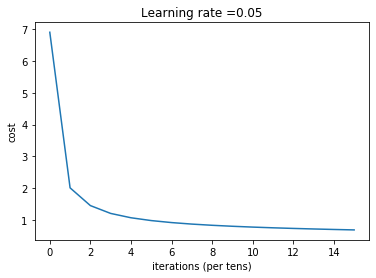

In [52]:
parameters = model_LL(X_train, Y_train, [28*28, 30, 10], 0.05, 800,0)

In [53]:
test_accuracy = predict(X_test,Y_test)

In [54]:
train_accuracy = predict(X_train,Y_train)

In [55]:
print("Train accuracy without L2 regularization --800 epocs-- : ", train_accuracy,"%")
print()
print("Test accuracy without L2 regularization --800 epocs --: ",test_accuracy,"%")

Train accuracy without L2 regularization --800 epocs-- :  90.65 %

Test accuracy without L2 regularization --800 epocs --:  91.29 %
